# Reinforcement Learning CAT 2 - Rishi 21110277

## Problem Statement

### Create a 100x100 grid with obstacles in between 2 random points. Build an MDP based RL agent to optimise both policies and actions at every state. Benchmark DP method with other RL solutions for the same problem.

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import random

## Step 1: Generating a 100x100 Grid Environment with Obstacles

In [80]:
GRID_SIZE = 100
OBSTACLE_RATIO = 0.2  # 20% of cells will be obstacles

## Create an empty grid with random obstacles

In [82]:
grid = np.zeros((GRID_SIZE, GRID_SIZE))

### Add obstacles

In [84]:
num_obstacles = int(GRID_SIZE * GRID_SIZE * OBSTACLE_RATIO)
for _ in range(num_obstacles):
    x, y = np.random.randint(0, GRID_SIZE, size=2)
    grid[x, y] = -1  # -1 for obstacles

### Define start and goal positions

In [86]:
start = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))
goal = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))
while grid[start] == -1 or grid[goal] == -1 or start == goal:
    start = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))
    goal = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))
    
grid[start] = 2  # Start position
grid[goal] = 3   # Goal position

### Displaying the grid

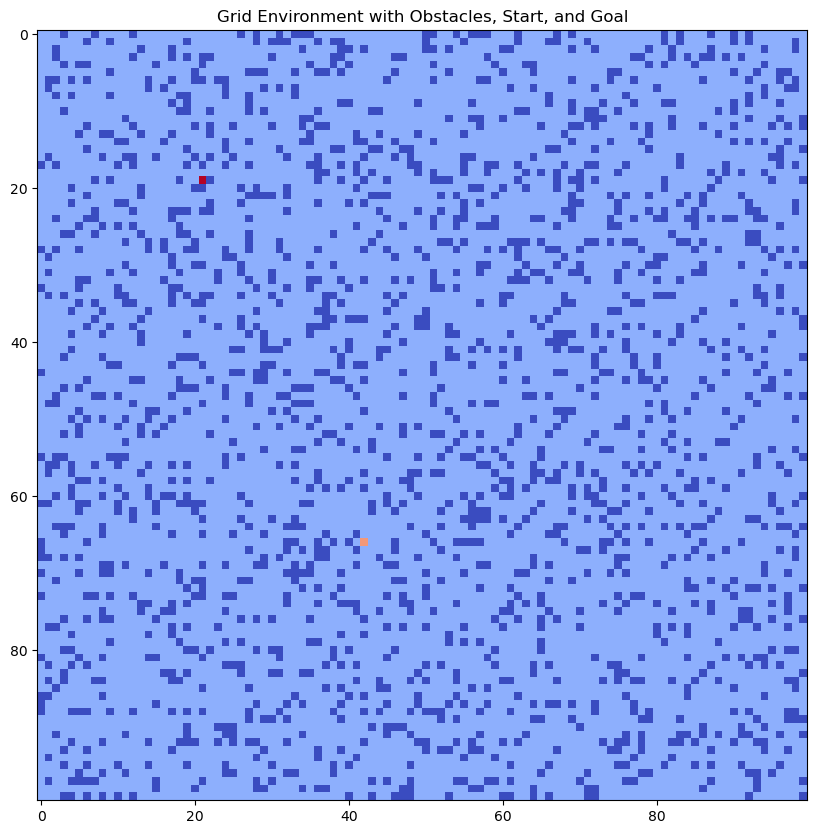

In [88]:
plt.figure(figsize=(10, 10))
plt.imshow(grid, cmap='coolwarm', origin='upper')
plt.title("Grid Environment with Obstacles, Start, and Goal")
plt.show()

## Step 2: Defining MDP Components

In [90]:
actions = ["up", "down", "left", "right"]
gamma = 0.9
reward_goal = 100
reward_obstacle = -10
reward_default = -1

### Define rewards for each cell

In [92]:
rewards = np.full((GRID_SIZE, GRID_SIZE), reward_default)
rewards[grid == 3] = reward_goal
rewards[grid == -1] = reward_obstacle

### Define transition model: Probability of reaching each neighboring cell

In [94]:
def get_next_state(state, action):
    x, y = state
    if action == "up" and x > 0:
        return (x - 1, y)
    elif action == "down" and x < GRID_SIZE - 1:
        return (x + 1, y)
    elif action == "left" and y > 0:
        return (x, y - 1)
    elif action == "right" and y < GRID_SIZE - 1:
        return (x, y + 1)
    return state  # No movement if action goes out of bounds

## Step 3: Implement Value Iteration (Dynamic Programming)

In [96]:
def value_iteration(rewards, gamma=0.9, threshold=1e-4):
    values = np.zeros_like(rewards, dtype=float)
    policy = np.empty_like(rewards, dtype=object)
    
    while True:
        delta = 0
        for x in range(GRID_SIZE):
            for y in range(GRID_SIZE):
                if (x, y) == goal or grid[x, y] == -1:
                    continue  # Skip terminal and obstacle cells
                
                # Calculate value of each action
                action_values = []
                for action in actions:
                    next_state = get_next_state((x, y), action)
                    nx, ny = next_state
                    action_values.append(rewards[nx, ny] + gamma * values[nx, ny])
                
                # Update value and policy
                best_value = max(action_values)
                best_action = actions[np.argmax(action_values)]
                delta = max(delta, abs(best_value - values[x, y]))
                values[x, y] = best_value
                policy[x, y] = best_action
        
        # Stop when the change is below threshold
        if delta < threshold:
            break

    return values, policy

In [97]:
# Get values and optimal policy using Value Iteration
values_vi, policy_vi = value_iteration(rewards)

In [98]:
## Step 4: Implementing Q-Learning (Comparison with DP)

In [99]:
def q_learning(rewards, episodes=5000, alpha=0.1, gamma=0.9, epsilon=0.1):
    q_values = np.zeros((GRID_SIZE, GRID_SIZE, len(actions)))

    for _ in range(episodes):
        state = start
        while state != goal:
            x, y = state
            
            # Choose action with epsilon-greedy policy
            if random.random() < epsilon:
                action_index = random.randint(0, len(actions) - 1)
            else:
                action_index = np.argmax(q_values[x, y])

            action = actions[action_index]
            next_state = get_next_state(state, action)
            nx, ny = next_state

            # Compute the reward and update Q-values
            reward = rewards[nx, ny]
            td_target = reward + gamma * np.max(q_values[nx, ny])
            q_values[x, y, action_index] += alpha * (td_target - q_values[x, y, action_index])

            state = next_state  # Move to next state
    
    # Extract policy from Q-values
    policy_q = np.empty_like(rewards, dtype=object)
    for x in range(GRID_SIZE):
        for y in range(GRID_SIZE):
            best_action_index = np.argmax(q_values[x, y])
            policy_q[x, y] = actions[best_action_index]
    
    return q_values, policy_q

In [100]:
# Get Q-values and policy using Q-learning
q_values_ql, policy_ql = q_learning(rewards)

## Step 5: Benchmark Results (Compare Policies from DP and Q-learning)

In [102]:
def plot_policy(policy, title):
    plt.figure(figsize=(10, 10))
    policy_grid = np.zeros((GRID_SIZE, GRID_SIZE), dtype=str)
    for x in range(GRID_SIZE):
        for y in range(GRID_SIZE):
            if grid[x, y] == -1:
                policy_grid[x, y] = 'X'  # Obstacle
            elif grid[x, y] == 2:
                policy_grid[x, y] = 'S'  # Start
            elif grid[x, y] == 3:
                policy_grid[x, y] = 'G'  # Goal
            else:
                policy_grid[x, y] = policy[x, y] if policy[x, y] is not None else ' '
    
    plt.imshow(grid, cmap='coolwarm', origin='upper')
    for (j, i), label in np.ndenumerate(policy_grid):
        plt.text(i, j, label, ha='center', va='center', color="black")
    plt.title(title)
    plt.show()

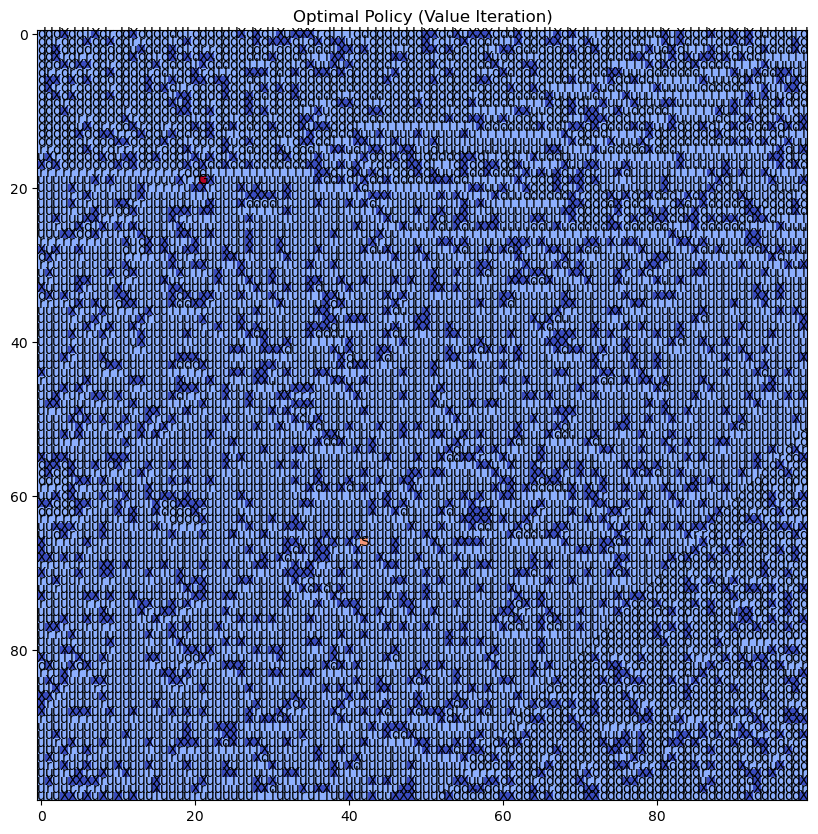

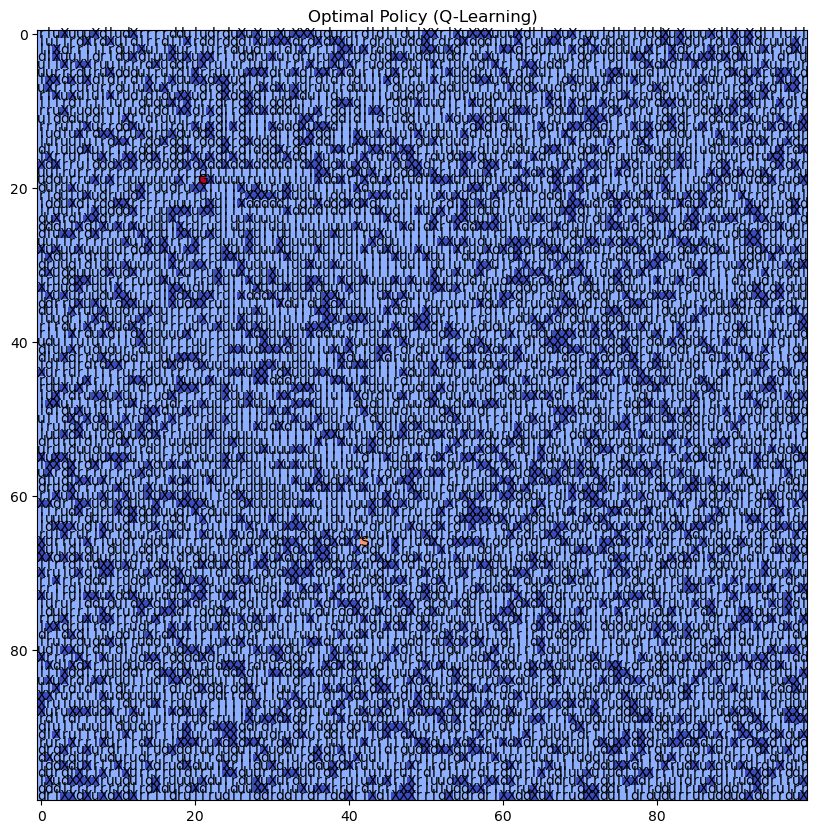

In [103]:
# Plot policies
plot_policy(policy_vi, "Optimal Policy (Value Iteration)")
plot_policy(policy_ql, "Optimal Policy (Q-Learning)")